# Heart Disease Prediction

### *Introduction*
The dataset that our group focuses on is the Coronary Artery Heart Disease data which records 14 attributes of patients in four regions: Cleveland, Hungary, Switzerland, and VA Long Beach. The attributes include age, stage of heart disease, blood pressure, and more.

For our project, we will be focusing on the predictive question,
- Can we predict patients’ stage of heart disease in Cleveland using the predictors age, resting blood pressure, serum cholesterol, and ST depression induced by exercise relative to rest?

We aim to build a classification model that predicts the condition of patients, classifying them in one of the five stages of heart disease (0-4). 0 means that the patients have no heart disease, and the others represent the severity of heart disease in increasing order. We also want to know if our model is accurate in making predictions.


In [1]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(GGally)
library(repr)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
set.seed(3456)
url <- "https://raw.githubusercontent.com/Jessieec/Group-Proposal/main/heart_disease_uci.csv"
heart_data <- read_csv(url)
heart_data

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id  age sex  dataset       cp              trestbps chol fbs  
1   1   63  Male Cleveland     typical angina  145      233   TRUE
2   2   67  Male Cleveland     asymptomatic    160      286  FALSE
3   3   67  Male Cleveland     asymptomatic    120      229  FALSE
⋮   ⋮   ⋮   ⋮    ⋮             ⋮               ⋮        ⋮    ⋮    
918 918 55  Male VA Long Beach asymptomatic    122      223   TRUE
919 919 58  Male VA Long Beach asymptomatic     NA      385   TRUE
920 920 62  Male VA Long Beach atypical angina 120      254  FALSE
    restecg          thalch exang oldpeak slope       ca thal              num
1   lv hypertrophy   150    FALSE 2.3     downsloping 0  fixed defect      0  
2   lv hypertrophy   108     TRUE 1.5     flat        3  normal            2  
3   lv hypertrophy   129     TRUE 2.6     flat        2  reversable defect 1  
⋮   ⋮                ⋮      ⋮     ⋮       ⋮           ⋮  ⋮                 ⋮  
918 st-t abnormality 100    FALSE  0      NA          NA fixed defect      2  
919 lv hypertrophy    NA       NA NA      NA          NA NA                0  
920 lv hypertrophy    93     TRUE  0      NA          NA NA                1

### *Preliminary exploratory data analysis*

In [3]:
heart_data_wrangled <- heart_data |>
    select(age, dataset, trestbps, chol, oldpeak, thalch, num) |>
    rename(region = dataset, heart_disease = num) |>
    filter(region == "Cleveland") |>
    mutate(heart_disease = as_factor(heart_disease)) |>
    mutate(heart_disease = fct_recode(heart_disease, "absent" = "0", "present" = "1", "present" = "2", "present" = "3", "present" = "4"))
    
heart_data_wrangled

age region    trestbps chol oldpeak thalch heart_disease
1   63  Cleveland 145      233  2.3     150    absent       
2   67  Cleveland 160      286  1.5     108    present      
3   67  Cleveland 120      229  2.6     129    present      
⋮   ⋮   ⋮         ⋮        ⋮    ⋮       ⋮      ⋮            
302 57  Cleveland 130      236  0       174    present      
303 38  Cleveland 138      175  0       173    absent       
304 28  Cleveland 130      132  0       185    absent

In [4]:
#training data
heart_data_split <- initial_split(heart_data_wrangled, prop = 0.75, strata = heart_disease)
heart_data_training <- training(heart_data_split)
heart_data_testing <- testing(heart_data_split)
heart_data_training

age region    trestbps chol oldpeak thalch heart_disease
1   63  Cleveland 145      233  2.3     150    absent       
2   37  Cleveland 130      250  3.5     187    absent       
3   44  Cleveland 120      263  0.0     173    absent       
⋮   ⋮   ⋮         ⋮        ⋮    ⋮       ⋮      ⋮            
225 57  Cleveland 140      241  0.2     123    present      
226 68  Cleveland 144      193  3.4     141    present      
227 57  Cleveland 130      131  1.2     115    present

In [5]:
# mean of selected predictors
heart_data_mean <- summarize(heart_data_training, 
                             age_mean = mean(age),
                             chol_mean = mean(chol), 
                             trestbps_mean = mean(trestbps),
                            oldpeak_mean = mean(oldpeak),
                            thalch_mean = mean(thalch, na.rm = TRUE)) |>
                    pivot_longer(cols = age_mean:thalch_mean,
                                 names_to = "variables",
                                 values_to = "mean")
heart_data_mean

# number of observations for each class
heart_data_observations <- group_by(heart_data_training, heart_disease) |>
    summarize(count = n())
heart_data_observations

# rows with missing data
heart_data_missing <- filter(heart_data_training, is.na(thalch) & is.na(trestbps) & is.na(chol) & is.na(heart_disease)) |>
    count()
heart_data_missing

variables     mean      
1 age_mean       54.753304
2 chol_mean     248.259912
3 trestbps_mean 132.427313
4 oldpeak_mean    1.080617
5 thalch_mean   149.436123

heart_disease count
1 absent        123  
2 present       104

n
1 0

- We have summarized our training data into 3 tables. One is for the mean of each of the variables. One is for the count of each of the stages. Since our count for absent and present is similar, we can continue making the model. If one variable had much more counts than the other, then our prediction could be high if our model was good at predicting only one of the variables but not good at predicting the other variable. We do not need to worry about missing data because our missing data count is 0 in our training data. 

In [46]:
#scale the data
recipe <- recipe(heart_disease ~ age + chol + trestbps + thalch + oldpeak, data = heart_data_training) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

heart_disease_scaled <- recipe |>  
                            prep() |> 
                            bake(heart_data_training)
heart_disease_scaled

age        chol        trestbps   thalch     oldpeak     heart_disease
1    0.9073674 -0.28716625  0.7104718 0.02413093  1.0100343  absent       
2   -1.9533603  0.03274557 -0.1371654 1.60753455  2.0040132  absent       
3   -1.1831644  0.27738403 -0.7022568 1.00840886 -0.8950918  absent       
⋮   ⋮          ⋮           ⋮          ⋮          ⋮           ⋮            
225 0.2471994  -0.1366195   0.4279261 -1.1313258 -0.72942869 present      
226 1.4575073  -1.0399000   0.6539626 -0.3610213  1.92118163 present      
227 0.2471994  -2.2066372  -0.1371654 -1.4736833  0.09888703 present

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


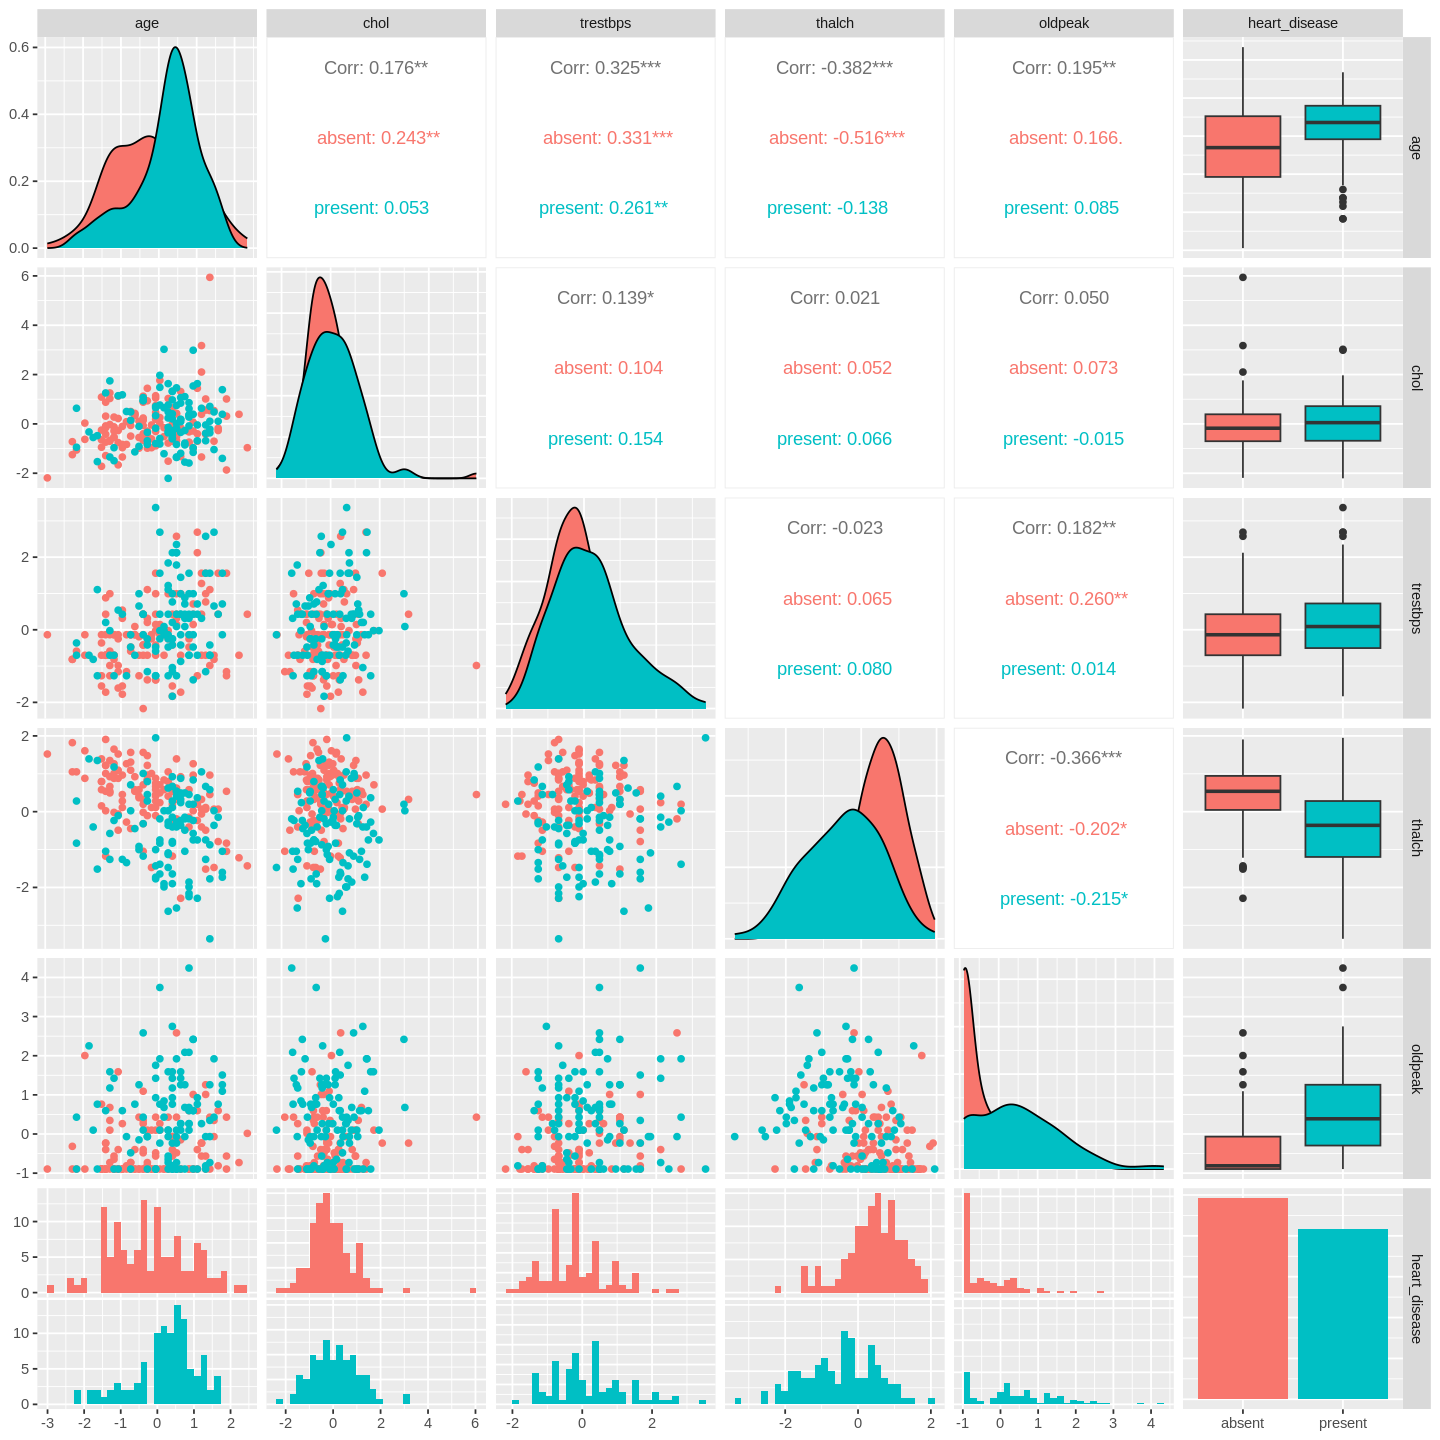

In [47]:
#graph for Age vs. Stage of Heart Disease
options(repr.plot.width = 12, repr.plot.height = 12)
Heart_Disease_Predictors_Plot <- heart_disease_scaled |> select(age:heart_disease) |>
     ggpairs(mapping = aes(color = heart_disease))
Heart_Disease_Predictors_Plot

- From each of the five variables, we can see that patients with heart disease and without heart disease are grouped on the graph. For example, there are areas concentrated with more blue points (present) and areas concentrated with more red points (absent) on the graph. This means that the five variables have a correlation to heart disease. The groups are not too distinct and many of the scatter plots shown in the matrix plot have groups of red and blue points mixed together. This means that we are most likely not going to get a high accuracy because k-nn classification classifies points based on the closest points. Without groups, the closest points of a red point could be blue points and the point will get wrongfull classified. 

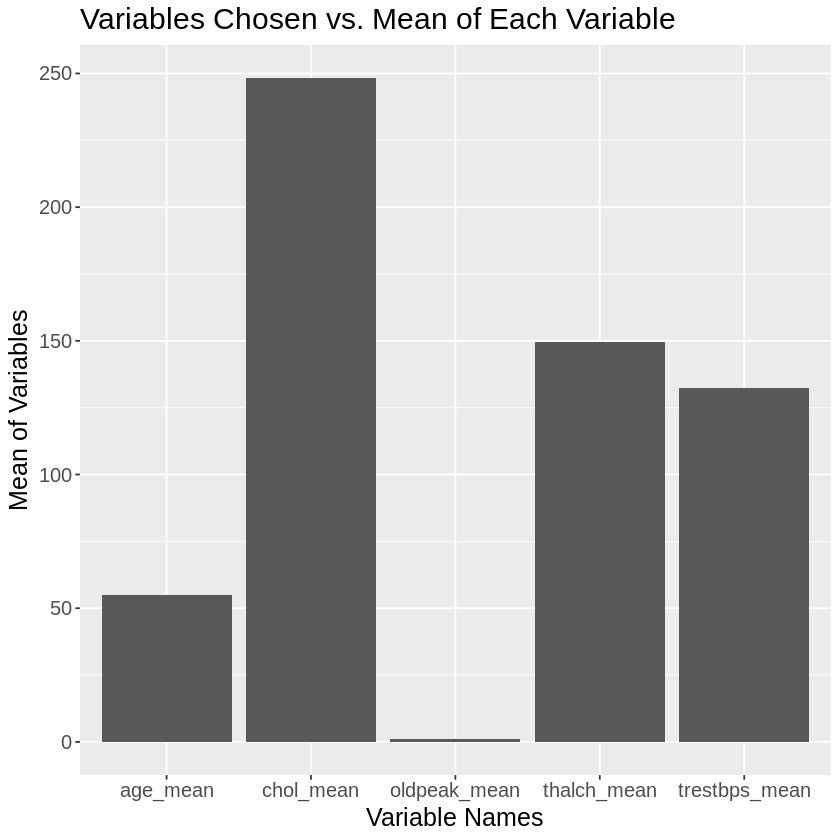

In [44]:
#graph for Mean Data
options(repr.plot.width = 7, repr.plot.height = 7)
heart_data_mean_plot <- heart_data_mean |>
    ggplot(aes(x = variables, y = mean)) +
    geom_bar(stat = "identity") +
    labs(x = "Variable Names", y = "Mean of Variables") +
    ggtitle("Variables Chosen vs. Mean of Each Variable") +
    theme(text = element_text(size = 15))
heart_data_mean_plot

#### *Note About Oldpeak on the Mean Bar Chart:*
- Since we will be scaling the data later on in our analysis, the oldpeak value being comparably smaller will not be an issue.

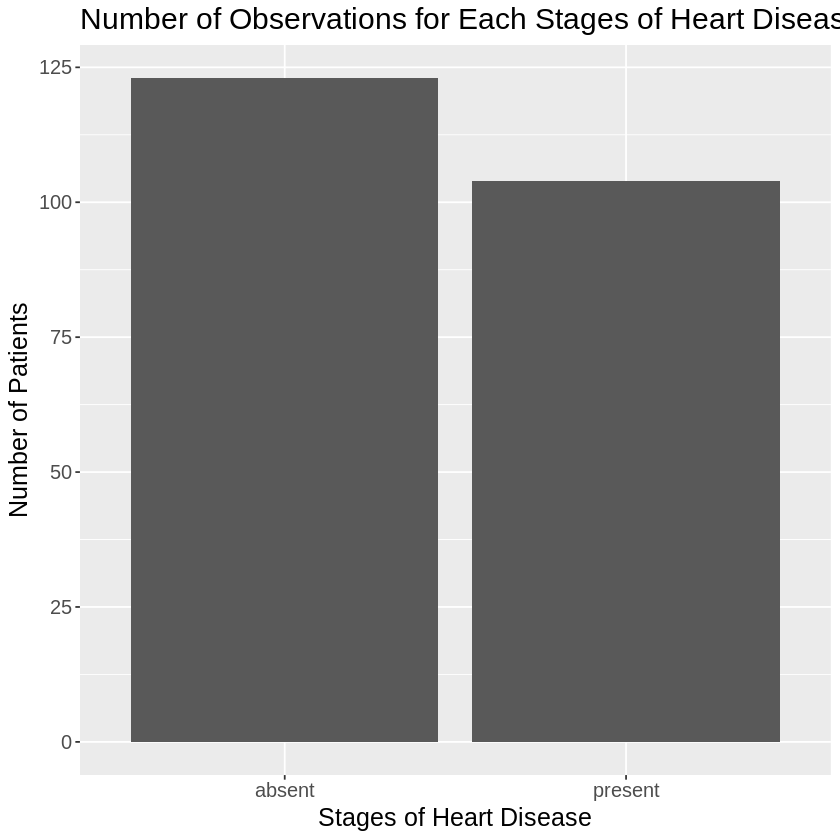

In [9]:
#graph for number of observations
# This section help us visualize the distribution of patients for different stages of heart disease
heart_data_observation_plot <- heart_data_observations |>
    ggplot(aes(x = heart_disease, y = count)) +
    geom_bar(stat = "identity") +
    labs(x = "Stages of Heart Disease", y = "Number of Patients") +
    ggtitle("Number of Observations for Each Stages of Heart Disease") +
    theme(text = element_text(size = 15))
heart_data_observation_plot

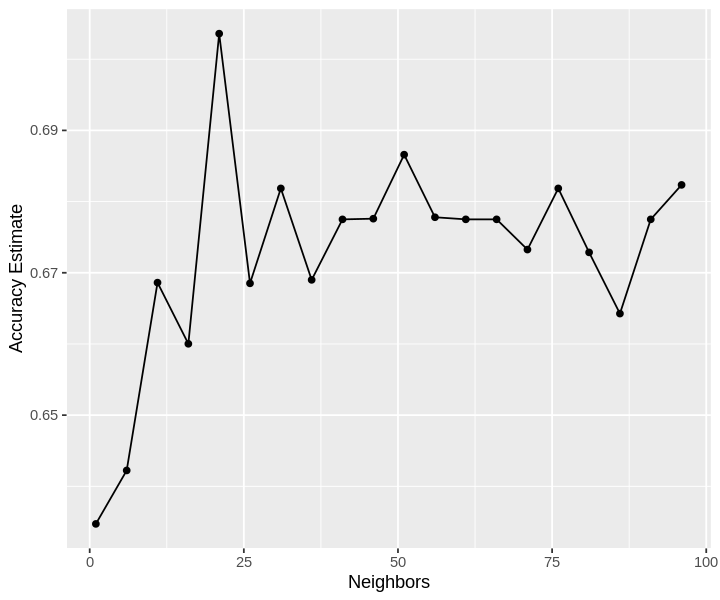

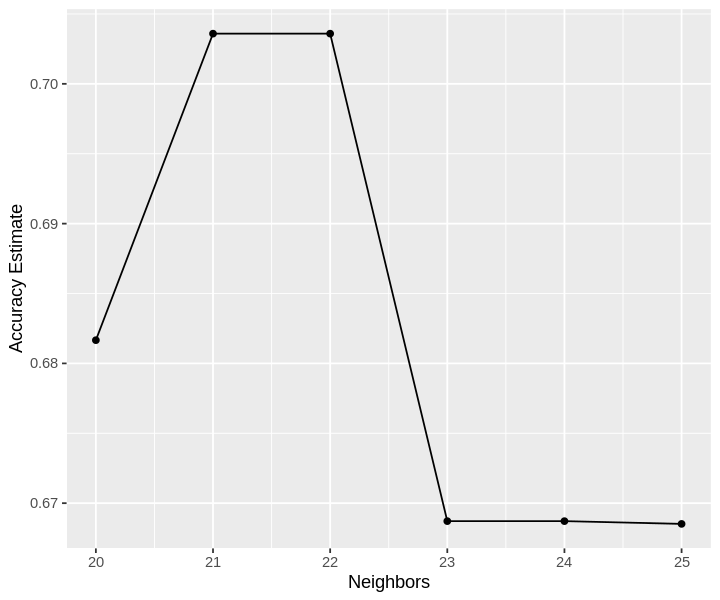

In [65]:
set.seed(1234) 

options(repr.plot.height = 5, repr.plot.width = 6)

heart_vfold <- vfold_cv(data = heart_data_training, v = 5, strata = heart_disease)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

heart_recipe <- recipe(heart_disease ~ age + chol + trestbps + thalch + trestbps, data = heart_data_training) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

values_1 <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

heart_fit_1 <- workflow() |>
                add_model(knn_tune) |>
                add_recipe(heart_recipe) |>
                tune_grid(resamples = heart_vfold, grid = values_1) |>
                collect_metrics() |>
                filter(.metric == "accuracy")

cross_val_plot_1 <- ggplot(heart_fit_1, aes(x = neighbors, y = mean)) + 
                    geom_point() + 
                    geom_line() + 
                    labs(x = "Neighbors", y = "Accuracy Estimate")

cross_val_plot_1

values_2 <- tibble(neighbors = seq(from = 20, to = 25, by = 1))

heart_fit_2 <- workflow() |>
                add_model(knn_tune) |>
                add_recipe(heart_recipe) |>
                tune_grid(resamples = heart_vfold, grid = values_2) |>
                collect_metrics() |>
                filter(.metric == "accuracy")

cross_val_plot_2 <- ggplot(heart_fit_2, aes(x = neighbors, y = mean)) + 
                    geom_point() + 
                    geom_line() + 
                    labs(x = "Neighbors", y = "Accuracy Estimate")

cross_val_plot_2

We graphed the neighbors from 0 to 100 and narrowed the scope on our highest peak. The best k-neighbors value that gives the highest accuracy estimate is between 21-22. 

In [66]:
set.seed(1234) 

heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
                set_engine("kknn") |>
                set_mode("classification")

heart_final_fit <- workflow() |>
            add_recipe(heart_recipe) |>
            add_model(heart_spec) |>
            fit(data = heart_data_training)

heart_final_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3215859
Best kernel: rectangular
Best k: 21

.metric  .estimator .estimate
1 accuracy binary     0.6753247

.metric   .estimator .estimate
1 precision binary     0.6923077

.metric .estimator .estimate
1 recall  binary     0.5142857

          Truth
Prediction absent present
   absent      34      17
   present      8      18

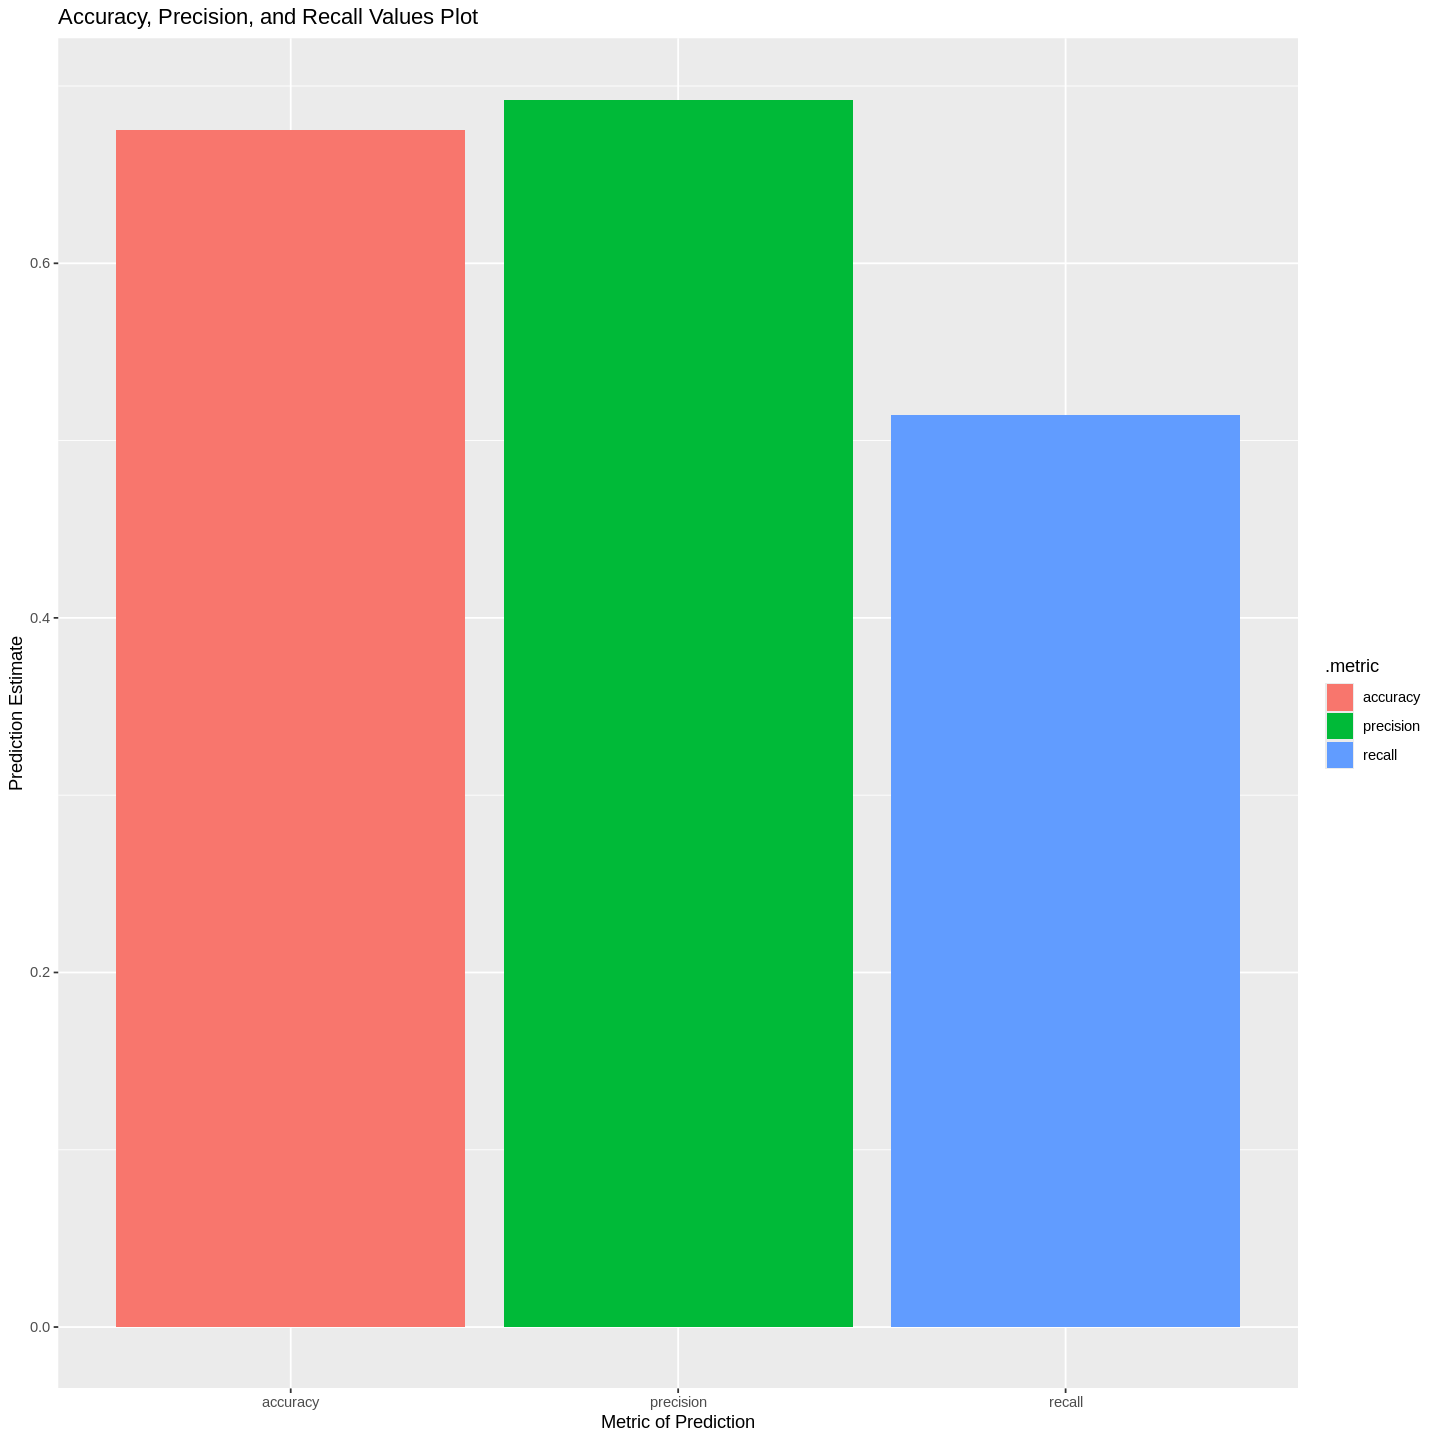

In [73]:
# Set the seed. Don't remove this!
set.seed(1234)

heart_predictions <- heart_final_fit |>
    predict(heart_data_testing) |>
    bind_cols(heart_data_testing)

heart_conf_mat <- heart_predictions |>
    conf_mat(truth = heart_disease, estimate = .pred_class)

heart_metrics <- heart_predictions |>
    metrics(truth = heart_disease, estimate = .pred_class) |>
    filter(.metric == "accuracy")

heart_metrics

precision <- heart_predictions |>
    precision(truth = heart_disease, estimate = .pred_class, event_level = "second")
precision

recall <- heart_predictions |>
    recall(truth = heart_disease, estimate = .pred_class, event_level = "second")
recall
heart_conf_mat

merge <- bind_rows(heart_metrics, precision, recall) 

metrics_bar_plot <- ggplot(merge, aes(x = .metric, y = .estimate, fill = .metric)) + 
                    geom_bar(stat = "identity") + 
                    labs(x = "Metric of Prediction", y = "Prediction Estimate", color = "Metric of Prediction") + 
                    ggtitle("Accuracy, Precision, and Recall Values Plot")

metrics_bar_plot

# all_metrics_plot <- ggplot(all_metrics, aes(x = sex, y = .estimate, fill = .metric)) +
# geom_bar(stat = "identity", position = "dodge") + 
# labs(fill = "Prediction Metric", x = "Sex", y = "Value", title = "Figure 5: Chart of evaluation metrics on testing sets")
# all_metrics_plot

- Our model has a 66.7% accuracy which is not very good. However, it has a 85.7% recall which is pretty good.
Recall is the number of correct positive predictions over the total positive observations. In our model, the positive predictions are 'present' and the negative predictions are 'absent'. Having a high recall is very important because recall tells us how accurate our positive predictions are. Not correctly diagnosing patients who have heart disease can be extremely fatal. Precision is the number of correct positive predictions over the total number of positive predictions. This tells us how many of our positive predictions are right. Our precision of 68.8% is not very good, but it is less fatal than having a low recall. Misdiagnosing someone with heart disease when they don’t have heart disease is not as deadly as not diagnosing someone with heart disease as they can't take appropriate actions towards treatment. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


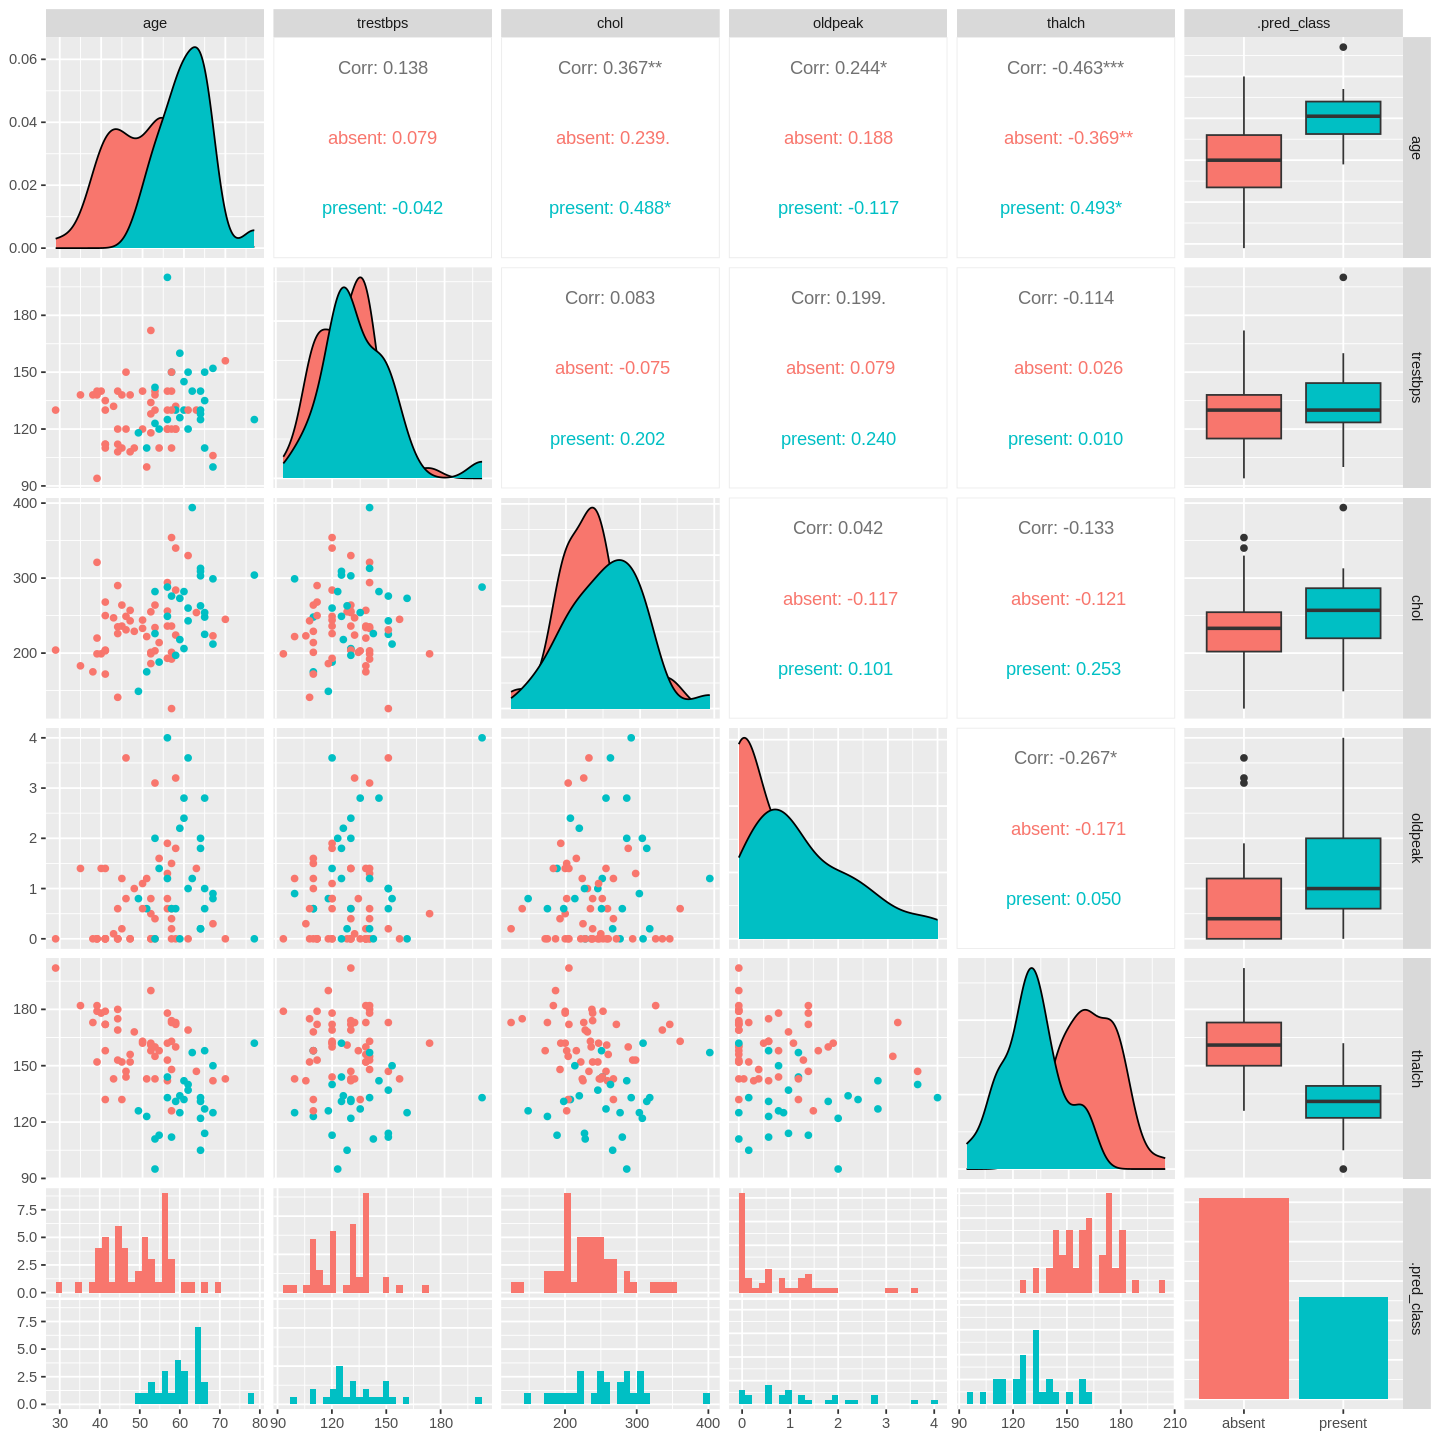

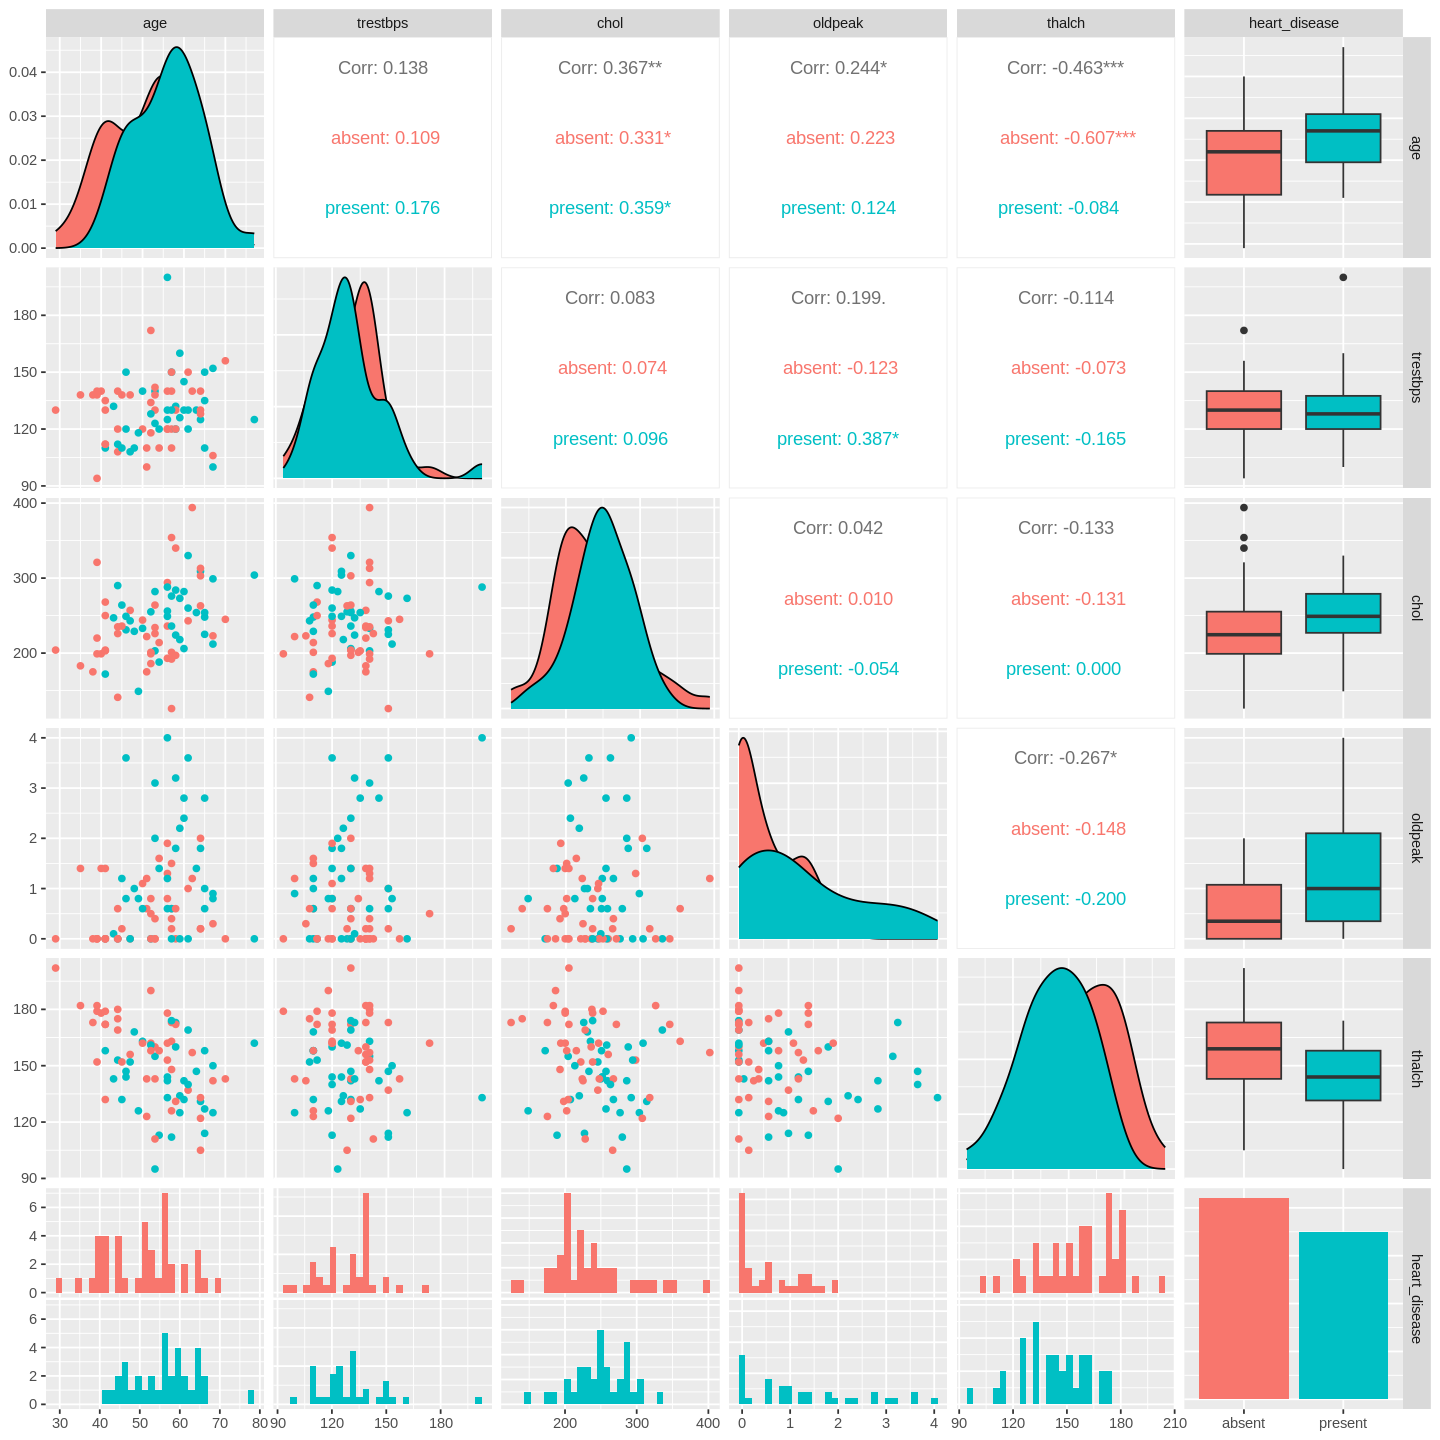

In [69]:
set.seed(1234)
options(repr.plot.width = 12, repr.plot.height = 12)

mnist_predictions_with_labels <- heart_predictions |> 
select(.pred_class) |>
bind_cols(heart_data_testing |> select (heart_disease)) |>
mutate(seq = 1:nrow(heart_predictions)) |>
as.data.frame()

predicted_labels <- mnist_predictions_with_labels |> select(.pred_class)

heart_testing_set <- bind_cols(heart_data_testing, predicted_labels)

#predicted diagnosis on testing data 
predicted_testing_diagnoses_plot <- heart_testing_set |> select(age, trestbps, chol, oldpeak, thalch, .pred_class) |> 
                                    ggpairs(mapping = aes(color = .pred_class))
predicted_testing_diagnoses_plot

#actual diagnosis on testing data 
testing_diagnoses_plot <- heart_testing_set |> select(age, trestbps, chol, oldpeak, thalch, heart_disease) |> 
                          ggpairs(mapping = aes(color = heart_disease))
testing_diagnoses_plot

# diagnosed_negative_patient <- heart_testing_set |> slice(73) 
# diagnosed_negative_patient

# diagnosed_positive_patient <- heart_testing_set |> slice(4) 
# diagnosed_negative_patient

# matching <- mnist_predictions_with_labels |>
# filter(.pred_class == heart_disease)
# matching

# not_matching <- mnist_predictions_with_labels |>
#      filter(.pred_class != heart_disease)
# not_matching

# actual_testing_diagnoses_plot <- heart_testing_set |> 
#                                      ggplot(aes(x = age, y = trestbps, color = heart_disease)) + 
#                                      geom_point() + 
#                                      labs(x = "Age (in years)", y = "Resting Blood Pressure (in mm/Hg)", color = "Actual Diagnosis") + 
#                                      ggtitle("Heart Disease Testing Data Diagnosis Plot")
# actual_testing_diagnoses_plot

# predicted_testing_diagnoses_plot <- heart_testing_set |> 
#                                     ggplot(aes(x = age, y = trestbps, color = .pred_class)) + 
#                                     geom_point() + 
#                                     labs(x = "Age (in years)", y = "Resting Blood Pressure (in mm/Hg)", color = "Predicted Diagnosis") + 
#                                     ggtitle("Heart Disease Testing Data Predicted Diagnosis Plot")

# diagnosed_negative_patient <- heart_testing_set |> slice(73) 
# diagnosed_negative_patient


# matching <- mnist_predictions_with_labels |>
# filter(.pred_class == y) |> 
# sample_n(3)
# heart_disease_labels <- heart_data_
# # random patient from our testing data with no heart disease 
# testing_patient_absent <- heart_data_testing |> slice(30)
# testing_patient_absent
# # random patient from our testing data with heart disease 
# testing_patient_present <- heart_data_testing |> slice(4)
# testing_patient_present

The first graph is the predicted diagnosis on our testing data and the second graph is the actual diagnosis on our testing data. We can see that the general groups are similar. For example, if there are more blue points in one area of the actual diagnosis graph, then there will be more blue points (present) in the same area in the predicted diagnosis graph. If there are more red points (absent) in one area of the actual diagnosis graph, then there will be more red points in the same area in the predicted diagnosis graph. We can see that our predicted diagnosis plot predicts way more red points (absent) than present, which is shown on the bottom right. The points on the actual diagnosis graph are more mixed together while the predicted diagnosis graph tends to have groups of all red and all blue. Because our neighbors value is high, we tend to have big generalized groups in the predicted diagnosis graph. 

In [35]:
#pick one patient 

# diagnosed_positive_patient <- heart_testing_set |> slice(4) 
# diagnosed_positive_patient

# predicted_testing_diagnoses_plot <- heart_testing_set |> 
#                                     ggplot(aes(x = age, y = trestbps, color = .pred_class)) + 
#                                     geom_point() + 
#                                     labs(x = "Age (in years)", y = "Resting Blood Pressure (in mm/Hg)", color = "Predicted Diagnosis") + 
#                                     ggtitle("Heart Disease Testing Data Predicted Diagnosis Plot")

# actual_testing_diagnoses_plot <- heart_testing_set |> 
#                                      ggplot(aes(x = age, y = trestbps, color = heart_disease)) + 
#                                      geom_point() + 
#                                      labs(x = "Age (in years)", y = "Resting Blood Pressure (in mm/Hg)", color = "Actual Diagnosis") + 
#                                      ggtitle("Heart Disease Testing Data Diagnosis Plot")
# actual_testing_diagnoses_plot


Here we plotted our scatter plots from our matrix plots above except we plot testing data instead of training data. 

In [ ]:
# set.seed(1234)

# patient <- tibble(age = 80, chol = 200)

# heart_predict <- predict(heart_final_fit, patient)

# heart_predict

In [ ]:
# heart_data_selected <- heart_data_wrangled |> select(age, chol, heart_disease)
# patient_point <- c(80, 200)
# options(repr.plot.width = 12, repr.plot.height = 8)
# heart_data_selected |>
#     ggplot(aes(x = age, 
#                y = chol, 
#                colour = heart_disease)) +
#         labs(x = "Age (in years)",
#              y = "Cholestoral (in mg/dl)",
#             colour = 'Stage of Heart Disease') +
#         geom_point(size = 2.5) +
#         theme(text = element_text(size = 20)) +
#         annotate("path", 
#                  x=patient_point[1] + 5*cos(seq(0,2*pi,length.out=50)),
#                  y=patient_point[2] + 0.1*sin(seq(0,2*pi,length.out=50))) 

### *Method*

- We chose four variables as our predictors: age, resting blood pressure (trestbps), serum cholesterol (chol), and ST depression induced by exercise relative to rest (oldpeak). We removed character and categorical variables because they are difficult to use as predictors in K-NN classification. The “thalach” column is excluded because maximum heart rate happens once. The chosen variables are better indicators because they represent the overall condition of a person.
- We will train our model to use K-NN classification to classify the stage of heart disease from 0 to 4 using our predictors.
- The visualization of scatterplot matrix will help us visualize the training data, with different colors representing disease stages, showing the relation between predictors and the stage of disease.
- Cross-validation will help us determine the best K-value. With the K-value, we can create the K-NN model by setting the mode to “classification” and the engine to “kknn”, and then scale the data using “recipe”. Then, we can use workflow to fit the model to the scaled data.
- The prediction accuracy will be calculated using the training model to classify the data from the testing data and then by dividing the number of correct predictions by the total number of predictions. 
We will optimize the accuracy by testing different training and testing data splits, and then by choosing the model with the highest accuracy.


### *Expected outcomes and significance*

*What do you expect to find?*
- We expect the results to show higher stages of heart disease in the elderly and individuals with higher blood pressure, cholesterol, and ST depression.

*What impact could such findings have?*
- Using models to predict heart disease stages is beneficial for early intervention.
- Sometimes, certain medical tests require a doctor's referral. Our model allows people to easily see for themselves if they are at risk for heart disease.

*What future questions could this lead to?*
- Is our model accurate for the general public (outside of our dataset)?
- How can we improve our model to use categorical and character variables as well to predict heart disease?
- Despite our model’s focus on Coronary Artery Disease, can our model accurately predict heart disease stages for other heart diseases of the general public?
